In [25]:
import numpy as np
import json
import subprocess
import os

In [49]:
# 自分自身をコピーして保存しておく ファイルを保存してから実行すること

import shutil
import datetime

t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
now = datetime.datetime.now(JST)
d = now.strftime('%Y-%m-%d_%H-%M-%S')


if not os.path.exists('./reports'):
    os.mkdir('reports')

shutil.copy2('stabilize_quality_reports.ipynb','./reports/stabilize_quality_reports_'+ d +'.ipynb')

'./reports/stabilize_quality_reports_2022-12-25_17-46-39.ipynb'

In [28]:
# パラメータの定義
sync_period = 10
sync_frame_length = 299
dir = '/media/psf/Home/Dropbox/Mac/Documents/vgdataset/'
# paths = {'C0003.MP4':'2019-04-03_07.27.36.json'}
paths = {'ichijo/C0009.MP4':'ichijo/2022-11-19_12-16-07.json'}
frame_offsets=np.linspace(-4.0,4.0,21) # frame offset min, frame offset max, number of datas

In [29]:
import glob
import os
def cleanUp(video_path = None):
    csv_list = glob.glob("../build/*.csv")
    # print(file_list)
    for f in csv_list:
        os.remove(f)
        print('Removed:',f)

    json_list = glob.glob("../build/*.json",recursive=False)
    for f in json_list:
        if f != "../build/compile_commands.json":
            print('Removed:',f)
            os.remove(f)
    
    if video_path is not None:
        # SyncTable消す
        # 角速度消す
        # 特徴点は取っておく
        dir_name = os.path.dirname(video_path)
        base_name = os.path.splitext(os.path.basename(video_path))[0]
        sync_table_json = os.path.join(dir_name,base_name)+'_st.json'
        angular_velocity_json = os.path.join(dir_name,base_name)+'.json'
        # os.remove(os.path.join(dir_name,base_name)+'_st.json')
        if os.path.isfile(sync_table_json):
            print(sync_table_json)
            os.remove(sync_table_json)
        if os.path.isfile(angular_velocity_json):
            print(angular_velocity_json)
            os.remove(angular_velocity_json)


In [30]:
cleanUp('/home/parallels/vgdataset/ichijo/C0003.MP4')

Removed: ../build/-4.0000_warped_estimated_angular_velocity.csv
Removed: ../build/2022-12-25_13-04-00_estimated_angular_velocity.csv
Removed: ../build/2.0000_warped_estimated_angular_velocity.csv
Removed: ../build/2022-12-25_12-50-19_estimated_angular_velocity.csv
Removed: ../build/latest_warped_estimated_angular_velocity.csv
Removed: ../build/latest_sync_table.csv
Removed: ../build/timestamp_2022-12-25_12-53-43_warped_estimated_angular_velocity.csv
Removed: ../build/2022-12-25_13-19-07_new_sync_table.csv
Removed: ../build/2022-12-25_12-41-43_estimated_angular_velocity.csv
Removed: ../build/timestamp_2022-12-25_12-39-34_warped_estimated_angular_velocity.csv
Removed: ../build/0.8000_warped_estimated_angular_velocity.csv
Removed: ../build/2022-12-25_13-05-39_sync_table.csv
Removed: ../build/2022-12-25_12-55-27_new_sync_table.csv
Removed: ../build/2022-12-25_13-09-06_estimated_angular_velocity.csv
Removed: ../build/2022-12-25_13-42-17_sync_table.csv
Removed: ../build/2022-12-25_13-05-39_n

In [31]:
def exec_vg(path,record,offset=None):
    if offset is None:
        cmd = './pixelwise_stabilizer -i ' + path + ' -c ILCE-6500i -l SEL1670Z -j ' + record + ' -z 1.3 -n -a -p ' + str(sync_period) + ' -s ' + str(sync_frame_length)
    else:
        cmd = './pixelwise_stabilizer -i ' + path + ' -c ILCE-6500i -l SEL1670Z -j ' + record + ' -z 1.3 -n -a -p ' + str(sync_period) + ' -s ' + str(sync_frame_length) + ' -x frame_offset_' + format(offset,'1.4f') + '.json'
    
    res = None
    try:
        print('cmd:',cmd)
        res = subprocess.check_call(cmd.split(),cwd="../build/")
    except:
        print("Error.")
    print(res)

In [32]:

from cProfile import label
import csv
import matplotlib.pyplot as plt

def openCSV(path):
    with open(path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダー行を読み飛ばし

        data = []
        for row in reader:
            data.append(row)

    legends = [i for i in header]
    data = [[float(i) for i in row] for row in data]  # 文字列を数値に変換

    # X軸に時間を、Y軸にデータをセット
    eavf = [row[legends.index('Estimated angular velocity frame')] for row in data]
    mavf = [row[legends.index('Measured angular velocity frame')] for row in data]
    a = [row[legends.index('a-skew')] for row in data]
    b = [row[legends.index('b-offset')] for row in data]
    return eavf,mavf,a,b

In [33]:
def plotSync(x,y,labelx,labely,title):
    plt.figure(figsize=(10,6))
    plt.plot(x,y,'bo-')
    plt.xlabel(labelx)
    plt.ylabel(labely)          
    # plt.legend()
    plt.title(title)
    plt.grid()    
    plt.show()

cmd: ./pixelwise_stabilizer -i /media/psf/Home/Dropbox/Mac/Documents/vgdataset/ichijo/C0009.MP4 -c ILCE-6500i -l SEL1670Z -j /media/psf/Home/Dropbox/Mac/Documents/vgdataset/ichijo/2022-11-19_12-16-07.json -z 1.3 -n -a -p 10 -s 299
0
/media/psf/Home/Dropbox/Mac/Documents/vgdataset/ichijo/C0009.MP4 /media/psf/Home/Dropbox/Mac/Documents/vgdataset/ichijo/2022-11-19_12-16-07.json


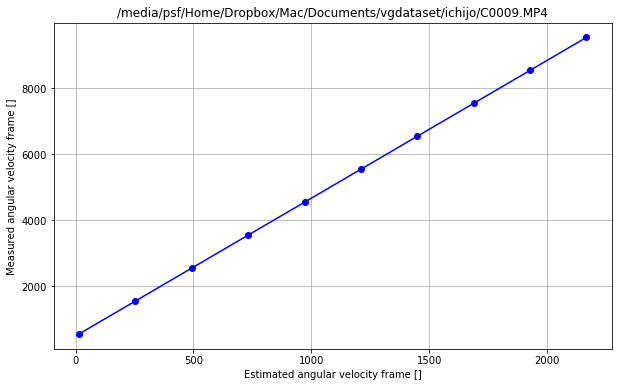

In [34]:
for p, r in paths.items():
    exec_vg(dir+p,dir+r)
    print(dir+p,dir+r)
    eavf,mavf,a,b = openCSV('../build/latest_sync_table.csv')
    plotSync(eavf,mavf,'Estimated angular velocity frame []','Measured angular velocity frame []',dir+p)
    

In [35]:
mavf

[541.2425,
 1541.673589,
 2542.544678,
 3542.915768,
 4543.166857,
 5543.957946,
 6544.609035,
 7545.160124,
 8545.691214,
 9546.242303]

In [36]:


for fo in frame_offsets:
    with open('../build/frame_offset_' + format(fo,'1.4f') + '.json', 'w') as f:
        obj={"frame_offset":fo, "path_prefix":format(fo,'1.4f')}
        json.dump(obj, f)

for p, r in paths.items():
    for fo in frame_offsets:
        exec_vg(dir+p,dir+r,fo)

cmd: ./pixelwise_stabilizer -i /media/psf/Home/Dropbox/Mac/Documents/vgdataset/ichijo/C0009.MP4 -c ILCE-6500i -l SEL1670Z -j /media/psf/Home/Dropbox/Mac/Documents/vgdataset/ichijo/2022-11-19_12-16-07.json -z 1.3 -n -a -p 10 -s 299 -x frame_offset_-4.0000.json
0
cmd: ./pixelwise_stabilizer -i /media/psf/Home/Dropbox/Mac/Documents/vgdataset/ichijo/C0009.MP4 -c ILCE-6500i -l SEL1670Z -j /media/psf/Home/Dropbox/Mac/Documents/vgdataset/ichijo/2022-11-19_12-16-07.json -z 1.3 -n -a -p 10 -s 299 -x frame_offset_-3.6000.json
0
cmd: ./pixelwise_stabilizer -i /media/psf/Home/Dropbox/Mac/Documents/vgdataset/ichijo/C0009.MP4 -c ILCE-6500i -l SEL1670Z -j /media/psf/Home/Dropbox/Mac/Documents/vgdataset/ichijo/2022-11-19_12-16-07.json -z 1.3 -n -a -p 10 -s 299 -x frame_offset_-3.2000.json
0
cmd: ./pixelwise_stabilizer -i /media/psf/Home/Dropbox/Mac/Documents/vgdataset/ichijo/C0009.MP4 -c ILCE-6500i -l SEL1670Z -j /media/psf/Home/Dropbox/Mac/Documents/vgdataset/ichijo/2022-11-19_12-16-07.json -z 1.3 -n

In [37]:

from cProfile import label
import csv
import matplotlib.pyplot as plt

def openCSV(path):
    with open(path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # ヘッダー行を読み飛ばし

        data = []
        for row in reader:
            data.append(row)

    legends = [i for i in header]
    data = [[float(i) for i in row] for row in data]  # 文字列を数値に変換
    # data = [print(row) for row in data]  # 文字列を数値に変換
    # X軸に時間を、Y軸にデータをセット
    t = [row[legends.index('Frame')] for row in data]
    rxw = [row[legends.index('rx')] for row in data]
    ryw = [row[legends.index('ry')] for row in data]
    rzw = [row[legends.index('rz')] for row in data]
    return t, rxw, ryw, rzw

# 角加速度を計算する関数を定義。戻り値の配列の長さが元の配列より１短い事に注意。
import numpy as np

def getAngularAcceleration(angular_velocity, sampling_rate):
    return (np.array(angular_velocity)[1:]-np.array(angular_velocity)[:-1])*sampling_rate

def getAverageOfAbsAngularAcceleration(angular_velocity, sampling_rate):
    return np.average(np.abs(getAngularAcceleration(angular_velocity,sampling_rate)))

def getTime(angular_velocity,sampling_rate):
    return np.linspace(0,len(angular_velocity)-1,len(angular_velocity))/sampling_rate

def getA4(angular_velocity,sampling_rate, length):
    time = getTime(angular_velocity,sampling_rate)
    a4 = []
    time_average = []
    for i in range(0,len(angular_velocity),length):
        a4.append(getAverageOfAbsAngularAcceleration(angular_velocity[i:i+length],sampling_rate))
        time_average.append(np.average(time[i:i+length])) 
    return time_average, a4

def plotA4s(angular_velocitys,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):
    plt.figure(figsize=(12,6))

    if legends is not None:
        for av,lb in zip(angular_velocitys,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            plt.plot(time_average,a4,label=lb)
    else:
        for av in angular_velocitys:
            time_average, a4 = getA4(av,sampling_rate,length)
            plt.plot(time_average,a4)

    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Time [second]')
    plt.ylabel('Average of Angular Acceleration [rad/s^2]')          
    plt.legend()
    plt.grid()




In [38]:
def plotRelativeA4s(angular_velocitys,original_angular_velocity,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):

    plt.figure(figsize=(10,6))

    if legends is not None:
        assert(angular_velocitys.shape[0] == original_angular_velocity.shape[0])
        assert(angular_velocitys.shape[0] == len(legends))
        for av,oav,lb in zip(angular_velocitys,original_angular_velocity,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            if lb == 'x_0.0000':
                plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),'--',label=lb,)
            else:
                print(np.shape(time_average))
                print(np.shape(np.array(a4)))
                print(np.shape(np.array(oa4)))
                plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),label=lb)
    else:
        for av,oav in zip(angular_velocitys,original_angular_velocity):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001))
    


    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Time [second]')
    plt.ylabel('Reduction ratio [ ]')     
    if legends is not None:     
        plt.legend()
    plt.grid()

np.shape(datas) (63, 2315)
np.shape(original_datas) (63, 2315)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(

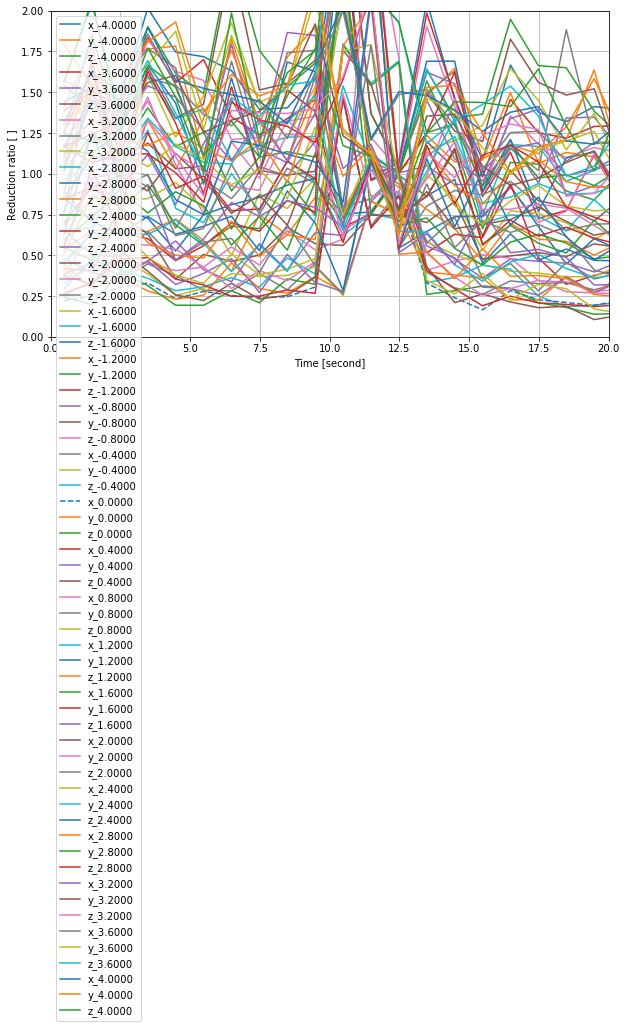

In [39]:
# 時系列方向のreduction ratioをまず表示。offset = 0のデータで良い。
# frame_offsets=np.linspace(-4.0,0.0,21)



legend = []
datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/' + numstr + '_warped_estimated_angular_velocity.csv')
    # legendを書く
    legend.append('x_' + numstr)
    legend.append('y_' + numstr)
    legend.append('z_' + numstr)
    
    # データを結合する
    if datas is None:
        datas = data[1:] 
    else:
        datas = np.append(datas,data[1:],axis=0) 

# legend = []
original_datas = None
for fo in frame_offsets:
    numstr = format(fo,'1.4f')
    # CSVを開く
    data = openCSV('../build/latest_estimated_angular_velocity.csv')
    # legendを書く
    # legend.append('x_' + numstr)
    # legend.append('y_' + numstr)
    # legend.append('z_' + numstr)
    

    # データを結合する
    if original_datas is None:
        original_datas = data[1:]
    else:
        original_datas = np.append(original_datas,data[1:],axis=0)

print('np.shape(datas)',np.shape(datas))
print('np.shape(original_datas)',np.shape(original_datas))
plotRelativeA4s(datas,original_datas, sampling_rate=30.,legends=legend,length=30,xlim=[0,20],ylim=[0,2])

(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,)
(78,

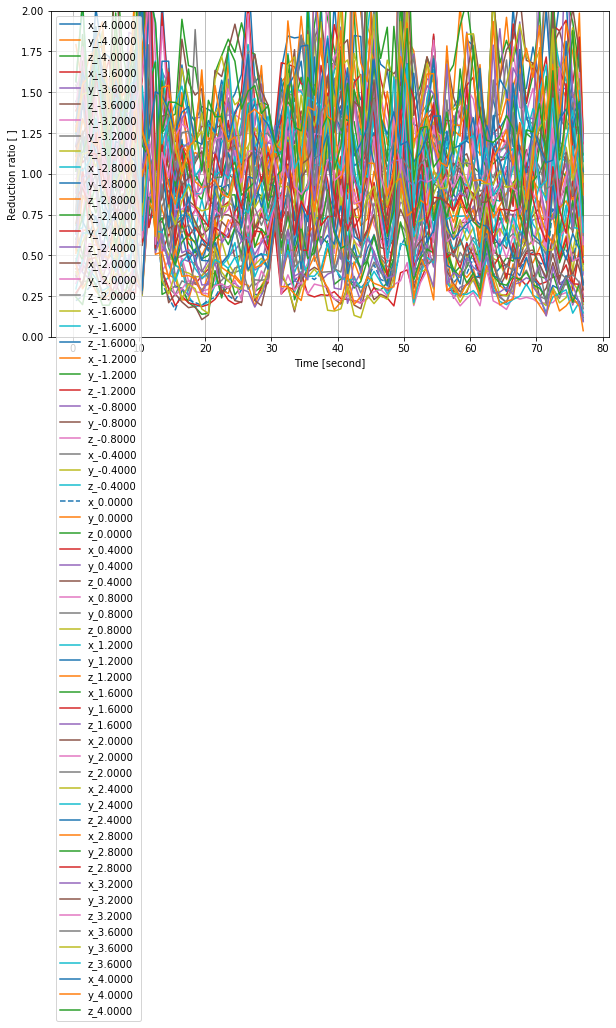

In [40]:
plotRelativeA4s(datas,original_datas, sampling_rate=30.,legends=legend,length=30,ylim=[0,2])

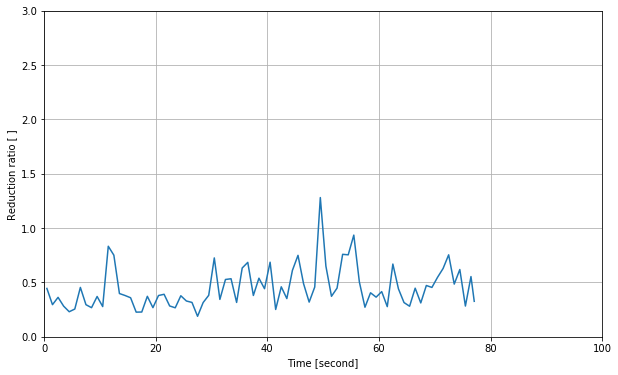

In [41]:
plotRelativeA4s([datas[int(datas.shape[0]/2)]],[original_datas[int(original_datas.shape[0]/2)]], sampling_rate=30.,length=30,xlim=[0,100],ylim=[0,3])

In [42]:
datas.shape[0]

63

In [43]:
def getAverageRelativeA4s(angular_velocitys,original_angular_velocity,frame_offset,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):

    ratio = []

    if legends is not None:
        assert(angular_velocitys.shape[0] == original_angular_velocity.shape[0])
        assert(angular_velocitys.shape[0] == len(legends))
        for av,oav,lb in zip(angular_velocitys,original_angular_velocity,legends):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            # plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001),label=lb)
            ratio.append(np.average(a4)/np.average(oa4))
    else:
        assert(angular_velocitys.shape[0] == original_angular_velocity.shape[0])
        for av,oav in zip(angular_velocitys,original_angular_velocity):
            time_average, a4 = getA4(av,sampling_rate,length)
            time_average, oa4 = getA4(oav,sampling_rate,length)
            # plt.plot(time_average,np.array(a4)/(np.array(oa4)+0.001))
            ratio.append(np.average(a4)/np.average(oa4))
        


    rsratio = np.reshape(np.array(ratio),(int(len(ratio)/3),3))

    
    return rsratio

In [44]:
min_red_tatio = []
ave_frame = []
# length = 200
length = 100
for i in range(0,len(datas[0])-1-length,length):
    red_ratio = getAverageRelativeA4s(datas[:,i:i+length],original_datas[:,i:i+length], frame_offset=frame_offsets, sampling_rate=30.,length=20)
    print(min(red_ratio[:,0]))
    if min(red_ratio[:,0]) is np.NaN:
        print(red_ratio)
    x_axis_ratio = red_ratio[:,0]
    x_axis_min_value_index = np.argmin(x_axis_ratio)
    
    min_red_tatio.append(frame_offsets[x_axis_min_value_index])
    ave_frame.append((i + length/2))

0.24916259167585947
0.29140638213813186
0.2536383155369019
0.8681129952698682
0.24539220373629267
0.20411544708294244
0.24653885486016813
0.23111773522911072
0.30114188809490966
0.4051517666697788
0.281305549878636
0.26819859314998185
0.22719854974349402
0.2541319634301411
0.23554243138426093
0.3293699230717062
0.6205818705431173
0.22394895319878208
0.28447407236249656
0.19015514515456314
0.24961832116600022
0.1979326217579392
0.23100810155425439


<ipython-input-45-5da43481ed63>:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a,b = np.linalg.lstsq(A,min_red_tatio)[0]


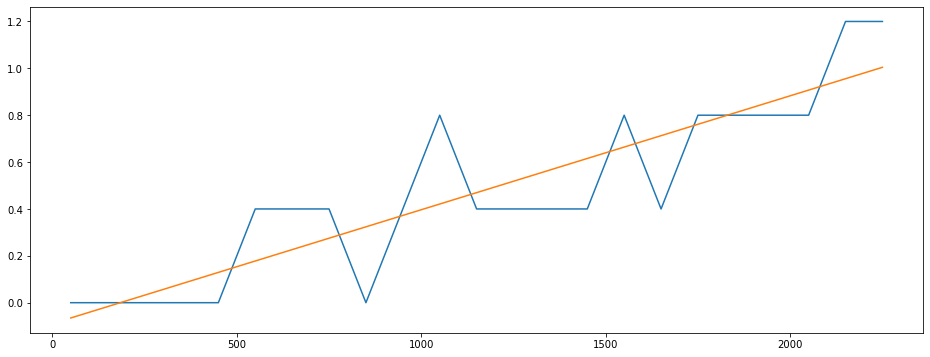

In [45]:
# 角加速度が最小となる時刻オフセット
A = np.array([ave_frame,np.ones(len(ave_frame))])
A = A.T
a,b = np.linalg.lstsq(A,min_red_tatio)[0]

plt.figure(figsize=(16,6))
plt.plot(ave_frame,min_red_tatio)
plt.plot(ave_frame,(a*np.array(ave_frame)+b))

In [46]:
import pprint

In [47]:
def plotAverageRelativeA4sNew(angular_velocitys,original_angular_velocitys,frame_offset,legends=None, sampling_rate=30., length=50,xlim=None,ylim=None):
    
    plt.figure(figsize=(10,6))

    for i in range(0,len(angular_velocitys[0])-1,length):
        # print(i,i+length)
        div_angular_velocity = angular_velocitys[:,i:i+length]
        div_original_angular_velocity = original_angular_velocitys[:,i:i+length]
        
        ratio = []

        if legends is not None:
            for av,oav,lb in zip(div_angular_velocity,div_original_angular_velocity,legends):

                time_average, a4 = getA4(av,sampling_rate,length)
                time_average, oa4 = getA4(oav,sampling_rate,length)
                # print(a4)
                # print(oa4)
                ratio.append(np.average(a4)/(np.average(oa4)+0.0001))
            ratio = np.array(ratio).reshape([int(len(ratio)/3),3])
            if i < 10*length:
                # print('frame_offset.shape:',frame_offset.shape)
                # print('len(ratio):',np.array(ratio).reshape([int(len(ratio)/3),3]))
                

                plt.plot(frame_offset,ratio,label=str(i))
            elif i < 20*length:
                plt.plot(frame_offset,ratio,'--',label=str(i))
            elif i < 30*length:
                plt.plot(frame_offset,ratio,'+',label=str(i))
            else:
                plt.plot(frame_offset,ratio,'o',label=str(i))
        else:
            for av,oav in zip(div_angular_velocity,div_original_angular_velocity):
                time_average, a4 = getA4(av,sampling_rate,length)
                time_average, oa4 = getA4(oav,sampling_rate,length)
                ratio.append(np.average(a4)/(np.average(oa4)+0.0001))
            plt.plot(frame_offset,ratio)

        # print('ratio',ratio)
        # rsratio = np.reshape(np.array(ratio),(int(len(ratio)/3),3))

        # print('frame_offset',frame_offset)
        # print('rsratio[:,0]',rsratio[:,0])
        # plt.plot(frame_offset,rsratio[:,0])
        
        

    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.xlabel('Frame [ ]')
    plt.ylabel('Reduction ratio [ ]')   
    if legends is not None:          
        plt.legend()
    plt.grid()
    plt.show()


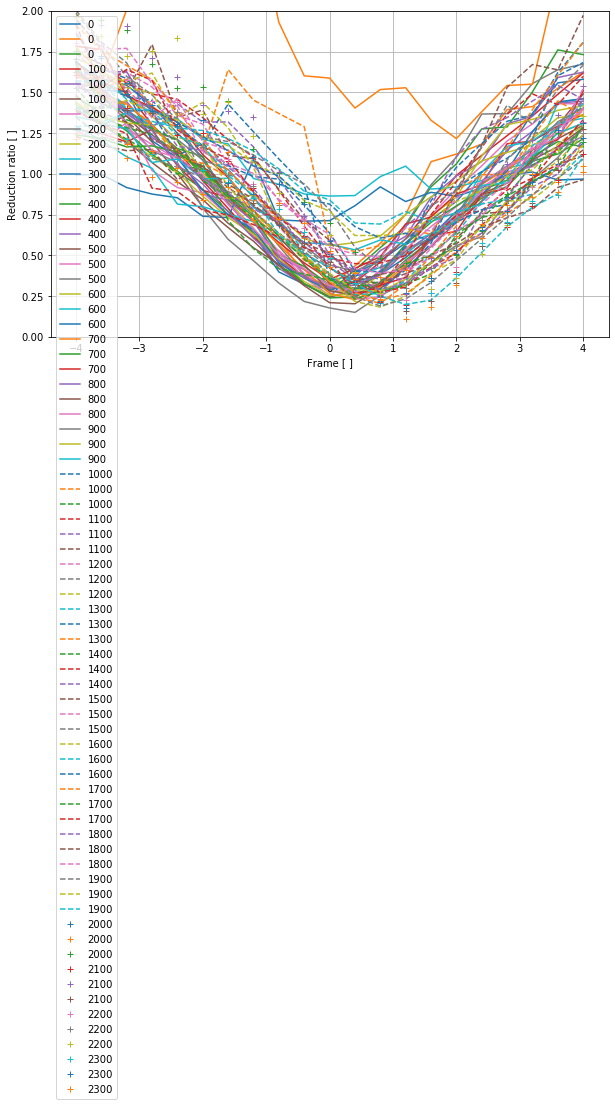

In [48]:
plotAverageRelativeA4sNew(datas,original_datas, frame_offsets, sampling_rate=30.,legends=legend,length=100,ylim=[0,2])